In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.quantization

#Dataloader


In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=(28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
image_test, label = train_dataset[4]
print("Shape của image", image_test.shape)

Shape của image torch.Size([1, 28, 28])


In [ ]:
class_name = train_dataset.classes
class_name

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

# Built Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, image):
        x = image.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = Net()
model = model.to(device)
device

'cuda:0'

# Train Model


In [ ]:
# train_step
def train_step(model: torch.nn.Module,
               dataset: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
      # setup train loss, acc
      train_loss, train_acc = 0, 0

      # put model into mode train
      model.train()

      # loop
      for batch, (X, y) in enumerate(dataset):
          #send X, y to device
          X, y = X.to(device), y.to(device)

          # 1. Forward
          y_pred = model(X)

          # 2. calculate loss
          loss = loss_fn(y_pred, y)
          train_loss += loss.item()

          # 3. optimizer zero grad
          optimizer.zero_grad()

          # 4. backward
          loss.backward()

          # 5. update the optim
          optimizer.step()

          y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
          train_acc += ((y_pred_class == y).sum().item()) / len(y_pred)
      
      # adjust metric
      train_loss = train_loss / len(dataset)
      train_acc = train_acc / len(dataset)
      return train_loss, train_acc
     

In [ ]:
# test_step
def test_step(model: torch.nn.Module,
              dataset: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module
              ):
  
    # setup test loss, acc
    test_loss, test_acc = 0, 0

    # put model into eval
    model.eval()

    # loop
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataset):
            # send X, y to device
            X, y = X.to(device), y.to(device)

            # 1. forward
            test_pred = model(X)

            # 2. calculate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = torch.argmax(torch.softmax(test_pred, dim = 1), dim=1)
            test_acc += ((test_pred_class == y).sum().item()) / len(test_pred)

        #adiust metric
        test_loss = test_loss / len(dataset)
        test_acc = test_acc / len(dataset)
        return test_loss, test_acc
     

In [ ]:
# ket hop train_step voi test_step
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int):

    # setup results
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    torch.manual_seed(42)

    # loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataset=train_loader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, dataset=test_loader, loss_fn=loss_fn)

        print(f'Epoch: {epoch+1}')
        print(f'Train_loss: {train_loss:.4f}')
        print(f'Train_acc: {train_acc:.2f}')
        print(f'Test_loss: {test_loss:.4f}')
        print(f'Test_acc: {test_acc:.2f}')

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results
     

In [ ]:
# training
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model_results = train(model=model, train_dataloader=train_loader, test_dataloader=test_loader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
Train_loss: 0.3691
Train_acc: 0.89
Test_loss: 0.2962
Test_acc: 0.91
Epoch: 2
Train_loss: 0.2966
Train_acc: 0.92
Test_loss: 0.2874
Test_acc: 0.92
Epoch: 3
Train_loss: 0.2852
Train_acc: 0.92
Test_loss: 0.2752
Test_acc: 0.92
Epoch: 4
Train_loss: 0.2806
Train_acc: 0.92
Test_loss: 0.2890
Test_acc: 0.92
Epoch: 5
Train_loss: 0.2766
Train_acc: 0.92
Test_loss: 0.2802
Test_acc: 0.92


# Lưu và kiểm tra model


In [ ]:
#save model
torch.save(model.state_dict(), "trained_model.pt")

#kiem tra kich thuoc model
import os

file_path = "trained_model.pt"
file_size = os.path.getsize(file_path)
print("File size:", file_size, "bytes")

#kiểm tra kiểu dữ liệu được sử dụng trong model
for name, param in model.named_parameters():
    print(f"Parameter '{name}' dtype: {param.dtype}")

File size: 32511 bytes
Parameter 'fc.weight' dtype: torch.float32
Parameter 'fc.bias' dtype: torch.float32


label true:  5
target_img torch.Size([1, 28, 28])
Final top pred: 5 - five
Time infer:  0.00012803077697753906


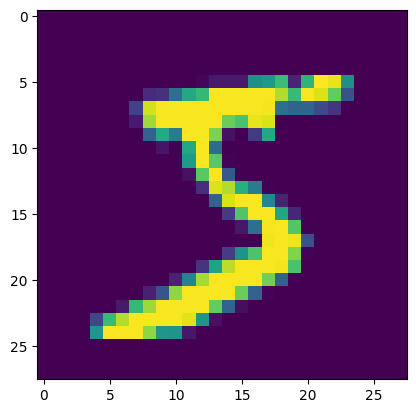

In [ ]:
import time
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

image_test, label = train_dataset[0]
print("label true: ", label)
transform_pred = transforms.Compose([
    transforms.Resize((28, 28))
])

target_img = transform_pred(image_test)
print("target_img", target_img.shape)
model.eval()

with torch.inference_mode():
    # them mot kic thuoc bo sung cho anh
    target_img = target_img.unsqueeze(dim=0)
    # make pred
    start = time.time()
    img_pred = model(target_img.to('cpu'))
    end = time.time()

time_infer = end - start
# 6. convert logist
img_pred_prob = torch.softmax(img_pred, dim=1)

import numpy as np
idx = torch.argmax(img_pred_prob, dim=1)

print('Final top pred: ' + class_name[idx])
print("Time infer: ", time_infer)
plt.imshow(target_img.squeeze())


# Đánh giá về ACC và time của model trên tập test_data


In [ ]:
# Evaluate the model on the test set
import time
model = model.to('cpu')
model.eval()
correct = 0
total = 0
sum_time = 0
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images
        labels = labels
        start = time.time()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        end = time.time()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if predicted == labels:
          probabilities = torch.softmax(outputs, dim=1)
          a = torch.max(probabilities)
          total_predictions = total_predictions + a

        average_probability = total_predictions/total
        time1 = end - start
        sum_time = sum_time + time1

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy}%')
print("time:", time1)
print("Xác xuất trung bình dự đoán mỗi ảnh trong toàn bộ tập ảnh: " + str(average_probability.item() *100) + "%")

Accuracy of the model on the test set: 92.16%
time: 5.340576171875e-05
Xác xuất trung bình dự đoán mỗi ảnh trong toàn bộ tập ảnh: 86.92319393157959%


# CONVERT model to ONNX

In [ ]:
%%capture
!pip install onnx
!pip install torchvision
!pip install onnx-tf
!pip install onnxruntime-gpu

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.onnx
import onnx

print("PyTorch version:", torch.__version__)
print("ONNX version:", onnx.__version__)

PyTorch version: 2.0.1+cu118
ONNX version: 1.14.0


In [ ]:
model = model.to('cpu')
dummy_input = Variable(torch.randn(1, 1, 28, 28)) 
torch.onnx.export(model, dummy_input, "model.onnx")



============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



# Quantize từ FP32 sang FB16

**convert_float_to_float16(model, min_positive_val=1e-7, max_finite_val=1e4, keep_io_types=False, disable_shape_infer=False, op_block_list=None, node_block_list=None)**

Float16 Tool Arguments

If the converted model does not work or has poor accuracy, you may need to set additional arguments.

model: The ONNX model to convert.

min_positive_val, max_finite_val: Constant values will be clipped to these 

bounds. 0.0, nan, inf, and -inf will be unchanged.

keep_io_types: Whether model inputs/outputs should be left as float32.

disable_shape_infer: Skips running onnx shape/type inference. Useful if shape inference is crashing, shapes/types are already present in the model, or types are not needed (types are used to determine where cast ops are needed for unsupported/blocked ops).

op_block_list: List of op types to leave as float32. By default uses the list from float16.DEFAULT_OP_BLOCK_LIST. This list has ops that are not supported for float16 in ONNX Runtime.

node_block_list: List of node names to leave as float32.

NOTE: Blocked ops will have have casts inserted around them to/from float16/float32. Currently, if two blocked ops are next to each other, the casts will still be inserted, creating a redundant pair. ORT will optimize this pair out at runtime, so the results will remain at full-precision.

In [ ]:
%%capture
!pip install onnxconverter_common

In [ ]:
import onnx
from onnxconverter_common import float16
model_onnx = '/content/model.onnx'
model_onnx = onnx.load(model_onnx)
model_quant_fl16 = float16.convert_float_to_float16(model_onnx)
onnx.save(model_quant_fl16, "/content/model_quant_fl16.onnx")

In [ ]:
#kiem tra kich thuoc
import os

file_path = "/content/model_quant_fl16.onnx"
file_size = os.path.getsize(file_path)
print("File size:", file_size, "bytes")

File size: 16195 bytes


# Kiểm tra model onnx_fl32 và onnx_fl16



Predicted class fl32: 5
Time infer fl32:  0.0010843276977539062
Predicted class fl16: 5
Time infer fl16:  0.0008058547973632812


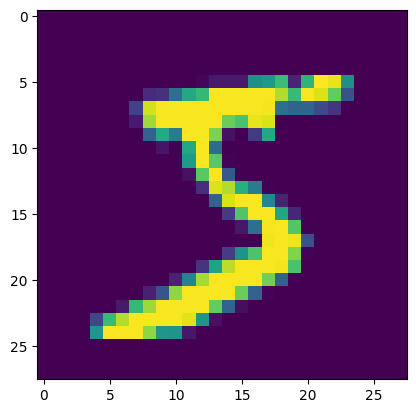

In [ ]:
import onnxruntime
import numpy as np
from PIL import Image
import time

# Đường dẫn đến mô hình ONNX
model_path = '/content/model.onnx'

# Đọc ảnh và chuyển đổi thành numpy array
image_array = np.array(image_test)
image_array = np.expand_dims(image_array, axis=0)  # Thêm chiều batch

# Khởi tạo môi trường ONNX Runtime và tạo session
ort_session_fl32 = onnxruntime.InferenceSession(model_path, providers=['CUDAExecutionProvider'])

# Chuẩn bị đầu vào cho mô hình
input_name_fl32 = ort_session_fl32.get_inputs()[0].name
image_fl32 = np.random.randn(1, 1, 28, 28).astype(np.float32)
image_array_fl32 = image_array.reshape(1, 1, 28, 28).astype('float32')
input_data_fl32 = {input_name_fl32: image_array_fl32}

start = time.time()
# Thực hiện inference
outputs_fl32 = ort_session_fl32.run(None, input_data_fl32)
end = time.time()

time_infer_fl32 = end - start

# Lấy kết quả dự đoán từ đầu ra của mô hình
predictions_fl32 = outputs_fl32[0]

# Hiển thị kết quả dự đoán
predicted_class_fl32 = np.argmax(predictions_fl32)
print("Predicted class fl32:", predicted_class_fl32)
print("Time infer fl32: ", time_infer_fl32)


# Đường dẫn đến mô hình ONNX
model_path = '/content/model_quant_fl16.onnx'

# Đọc ảnh và chuyển đổi thành numpy array
image_array = np.array(image_test)
image_array = np.expand_dims(image_array, axis=0)  # Thêm chiều batch

# Khởi tạo môi trường ONNX Runtime và tạo session
ort_session_fl16 = onnxruntime.InferenceSession(model_path, providers=['CUDAExecutionProvider'])

# Chuẩn bị đầu vào cho mô hình
input_name_fl16 = ort_session_fl16.get_inputs()[0].name
image_fl16 = np.random.randn(1, 1, 28, 28).astype(np.float16)
image_array_fl16 = image_array.reshape(1, 1, 28, 28).astype('float16')
input_data_fl16 = {input_name_fl16: image_array_fl16}

start = time.time()
# Thực hiện inference
outputs_fl16 = ort_session_fl16.run(None, input_data_fl16)
end = time.time()

time_infer_fl16 = end - start

# Lấy kết quả dự đoán từ đầu ra của mô hình
predictions_fl16 = outputs_fl16[0]

# Hiển thị kết quả dự đoán
predicted_class_fl16 = np.argmax(predictions_fl16)
print("Predicted class fl16:", predicted_class_fl16)
print("Time infer fl16: ", time_infer_fl16)
plt.imshow(target_img.squeeze())

# So sánh về ACC và time của onnx fp32 và fp16


In [ ]:
import numpy as np
import time
correct = 0
total = 0
total_time = 0
total_predictions = 0
for batch, (X, y) in enumerate(test_loader):

    for count, x in enumerate(X):
        x = np.expand_dims(x, 0).astype(np.float32)
        x = x.reshape(1, 1, 28, 28).astype('float32')
        input_data_fl32 = {input_name_fl32: x}
        # Run inference
        start_time = time.time()
        outputs_fl32 = ort_session_fl32.run(None, input_data_fl32)
        end_time = time.time()

        total_time = total_time + end_time - start_time
        output_tensor_fl32 = torch.from_numpy(outputs_fl32[0])
        _, predicted = torch.max(output_tensor_fl32, 1)
        if (predicted == y[count]):
          correct = correct+1
          probabilities = torch.softmax(output_tensor_fl32, dim=1)
          a = torch.max(probabilities)
          total_predictions = total_predictions + a

        total = total+1
average_probability = total_predictions/total       
print('Accuracy fl32: ', correct/total)
print('Total time fl32: {:.4f}'.format(total_time))
print("Xác xuất trung bình dự đoán mỗi ảnh trong toàn bộ tập ảnh(onnx_fl32): " + str(average_probability.item() *100) + "%")

correct = 0
total = 0
total_time = 0
total_predictions = 0
for batch, (X, y) in enumerate(test_loader):

    for count, x in enumerate(X):
        x = np.expand_dims(x, 0).astype(np.float16)
        x = x.reshape(1, 1, 28, 28).astype('float16')
        input_data_fl16 = {input_name_fl16: x}
        # Run inference
        start_time = time.time()
        outputs_fl16 = ort_session_fl16.run(None, input_data_fl16)
        end_time = time.time()

        total_time = total_time + end_time - start_time
        output_tensor_fl16 = torch.from_numpy(outputs_fl16[0]).float()
        _, predicted = torch.max(output_tensor_fl16, 1)
        if (predicted == y[count]):
          correct = correct+1
          probabilities = torch.softmax(output_tensor_fl16, dim=1)
          a1 = torch.max(probabilities)
          total_predictions = total_predictions + a1
        total = total +1

average_probability = total_predictions/total
        
print('Accuracy fl16: ', correct/total)
print('Total time fl32: {:.4f}'.format(total_time))
print("Xác xuất trung bình dự đoán mỗi ảnh trong toàn bộ tập ảnh(onnx_fl16): " + str(average_probability.item() *100) + "%")

Accuracy fl32:  0.9216
Total time fl32: 1.1757
Xác xuất trung bình dự đoán mỗi ảnh trong toàn bộ tập ảnh(onnx_fl32): 86.92319393157959%
Accuracy fl16:  0.9217
Total time fl32: 1.1022
Xác xuất trung bình dự đoán mỗi ảnh trong toàn bộ tập ảnh(onnx_fl16): 86.92911863327026%
